# Test formality among integrated verbs
The comparison against newspaper data provides extrinsic evidence that verb integration is associated with formality, since newspapers consistently use integrated verbs at a higher rate than social media authors.

Can we get *intrinsic* evidence for this, too? We will look at typical metrics for formality (e.g. word length) in all posts that contain a loanword or native word, while ignoring the word itself, and then compare the rate of formal language in posts with/without integrated verbs.

## Load data

In [ ]:
# load post data
import pandas as pd
use_cols = ['screen_name', 'id', 'text', 'has_light_verb']
loanword_use_cols = use_cols + ['loanword_verb']
native_verb_use_cols = use_cols
loanword_data = pd.read_csv('../../data/mined_tweets/loanword_verbs_post_social_data.tsv', sep='\t', usecols=loanword_use_cols)
native_verb_data = pd.read_csv('../../data/mined_tweets/native_verbs_post_social_data.tsv', sep='\t', usecols=native_verb_use_cols)

Sanity check: how many posts are at the character limit?

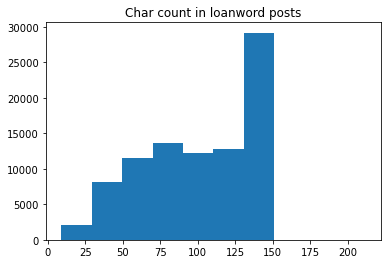

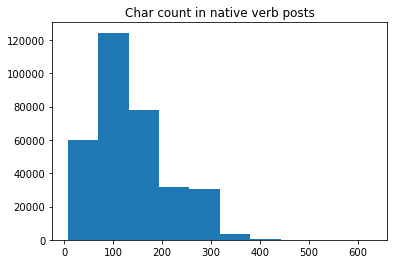

In [58]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(loanword_data.loc[:, 'text'].apply(len))
plt.title('Char count in loanword posts')
plt.show()
plt.hist(native_verb_data.loc[:, 'text'].apply(len))
plt.title('Char count in native verb posts')
plt.show()

OK! We will assume that those extra characters are due to URLs and not hitting the character limit.

In [8]:
# native verbs to remove from text
import re
from data_helpers import conjugate_verb, conjugate_light_verb, remove_ambiguous_verb_forms
native_verb_query_data = pd.read_csv('../../data/loanword_resources/native_verb_light_verb_pairs.csv', sep=',')# generate queries
native_verb_query_data = native_verb_query_data.assign(**{
    'integrated_verb_query' : native_verb_query_data.loc[:, 'integrated_verb'].apply(lambda x: re.compile('|'.join(remove_ambiguous_verb_forms(conjugate_verb(x))))),
    'light_verb_query' : native_verb_query_data.loc[:, 'light_verb'].apply(lambda x: re.compile('|'.join(list(map(lambda y: f'({y})', conjugate_light_verb(x)))))),
})
# get matchers
native_verb_matchers = (
    native_verb_query_data.loc[:, 'integrated_verb_query'].apply(lambda x: re.compile(x)).values.tolist() + 
    native_verb_query_data.loc[:, 'light_verb_query'].apply(lambda x: re.compile(x)).values.tolist()
)
print(native_verb_query_data.head())
def match_any(text, matchers):
    for matcher in matchers:
        match_result = matcher.search(text)
        if(match_result is not None):
            return match_result.group(0)
    return ''
native_verb_data = native_verb_data.assign(**{
    'clean_text' : native_verb_data.loc[:, 'text'].apply(lambda x: x.lower())
})
native_verb_data = native_verb_data.assign(**{
    'native_verb' : native_verb_data.loc[:, 'clean_text'].apply(lambda x: match_any(x, native_verb_matchers))
})
print(native_verb_data.loc[:, 'native_verb'].head(10))

  integrated_verb  ...                                   light_verb_query
0          pasear  ...  re.compile('(di un paseo)|(dimos un paseo)|(di...
1          viajar  ...  re.compile('(hice un viaje)|(hicimos un viaje)...
2         estimar  ...  re.compile('(tuve estima)|(tuvimos estima)|(tu...
3          multar  ...  re.compile('(puse una multa)|(pusimos una mult...
4        castigar  ...  re.compile('(puse un castigo)|(pusimos un cast...

[5 rows x 4 columns]
0       termina
1        compra
2    recomienda
3      pregunta
4      pregunta
5       termina
6       termina
7     disculpas
8     disculpas
9       termina
Name: native_verb, dtype: object


In [19]:
## combine data
loanword_data = loanword_data.rename(columns={'loanword_verb':'verb'}, inplace=False).assign(**{'post_verb_type':'loanword'})
native_verb_data = native_verb_data.rename(columns={'native_verb':'verb'}, inplace=False).assign(**{'post_verb_type':'native_verb'}).drop('clean_text', axis=1)
combined_post_data = pd.concat([loanword_data, native_verb_data], axis=0)
display(combined_post_data.head())
# get stats for verb counts
print(pd.crosstab(combined_post_data.loc[:, 'has_light_verb'], combined_post_data.loc[:, 'post_verb_type']))

post_verb_type  loanword  native_verb
has_light_verb                       
0                  61680       313875
1                  27873        14776


In [21]:
## remove verbs from text
combined_post_data = combined_post_data.assign(**{
    'clean_text' : combined_post_data.loc[:, 'text'].apply(lambda x: x.lower())
})
combined_post_data = combined_post_data.assign(**{
    'clean_text_no_verb' : combined_post_data.apply(lambda x: x.loc['clean_text'].replace(x.loc['verb'],''), axis=1)
})
display(combined_post_data.loc[:, ['text','clean_text_no_verb']].head().values)

array([['@Sheiladarsy @anticuarta4 Y dime tu cuales 7.6 mill?los retamos con medios internacionales auditamos la votacione d… https://t.co/ekpmWKx7q3',
        '@sheiladarsy @anticuarta4 y dime tu cuales 7.6 mill?los retamos con medios internacionales  la votacione d… https://t.co/ekpmwkx7q3'],
       ['@adameamiro Eres tan hipocrita que antes nos hablabas bien nomas te baneamos y ya dices puras mamadas que hipocrita eres :D',
        '@adameamiro eres tan hipocrita que antes nos hablabas bien nomas te  y ya dices puras mamadas que hipocrita eres :d'],
       ['@LVPibai Ibai te hace una normal de reclu? Así al menos baneamos y no te juegas nada, prometo pasar un buen rato',
        '@lvpibai ibai te hace una normal de reclu? así al menos  y no te juegas nada, prometo pasar un buen rato'],
       ['Me echaba unas rankeds ahora que flipas',
        'me echaba unas rankeds ahora que '],
       ['@MiiKeLMsT MIKEEL! CASI ME BANEAN POR COMPRAR EN IGVAULT ! No deberías de patrocinarlo ya que 

In [23]:
## filter to original data
# identify RT and URL shares to isolate only original text
import re
RT_matcher = re.compile('RT @\w+')
URL_matcher = re.compile('(?<=^https://)[a-zA-Z0-9\-]+\.[a-zA-Z0-9\-]+(?=/)|(?<=^)[a-zA-Z0-9\-]+\.[a-zA-Z0-9\-]+(?=/)|(?<=youtube\.com/watch\?v=)[a-zA-Z0-9_\-]+|(?<=youtu\.be/)[a-zA-Z0-9_\-]+|(?<=spotify\.com/track/)[a-zA-Z0-9]+|https?://[^\s]+|t\.co[^\s]+|pic.twitter.com[^\s]+')
combined_post_data = combined_post_data.assign(**{
    'has_shared_content' : combined_post_data.loc[:, 'text'].apply(lambda x: RT_matcher.search(x) is not None)
})
combined_post_data = combined_post_data.assign(**{
    'has_URL' : combined_post_data.loc[:, 'text'].apply(lambda x: URL_matcher.search(x) is not None)
})
original_post_data = combined_post_data[~(combined_post_data.loc[:, 'has_shared_content'] | combined_post_data.loc[:, 'has_URL'])]
print('%d/%d original posts'%(original_post_data.shape[0], combined_post_data.shape[0]))

261510/418204 original posts


In [24]:
# clean @-mentions, #hashtags
import re
mention_matcher = re.compile('@\w+')
hashtag_matcher = re.compile('#[^ \.\?!;:,\-]+')
def clean_social(text):
    text = mention_matcher.sub('', text)
    text = hashtag_matcher.sub('', text)
    return text
original_post_data = original_post_data.assign(**{
    'clean_text_no_social' : original_post_data.loc[:, 'clean_text_no_verb'].apply(lambda x: clean_social(x))
})

Now! Let's extract the formality variables:

- word length
- type/token ratio
- sentence length

In [38]:
# extract words, sentences
from data_helpers import BasicTokenizer
from nltk.tokenize import PunktSentenceTokenizer
lang = 'spanish'
word_tokenizer = BasicTokenizer(lang=lang)
sent_tokenizer = PunktSentenceTokenizer()
# word tokens
original_post_data = original_post_data.assign(**{
    'text_tokens' : original_post_data.loc[:, 'clean_text_no_social'].apply(lambda x: word_tokenizer.tokenize(x))
})
original_post_data = original_post_data.assign(**{
    'text_sents' : original_post_data.loc[:, 'clean_text_no_social'].apply(lambda x: list(map(lambda y: word_tokenizer.tokenize(y), sent_tokenizer.tokenize(x))))
})
# remove posts with no tokens?? social + verb
original_post_data = original_post_data[original_post_data.loc[:, 'text_tokens'].apply(len) > 0]

In [51]:
# fix dep variable type
verb_type_lookup = {0:'integrated_verb', 1:'light_verb'}
original_post_data = original_post_data.assign(**{
    'verb_form' : original_post_data.loc[:, 'has_light_verb'].apply(verb_type_lookup.get)
})

In [43]:
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import compute_word_length, compute_type_token_ratio, compute_sentence_length
original_post_data = original_post_data.assign(**{
    'word_len' : original_post_data.loc[:, 'text_tokens'].apply(lambda x: compute_word_length(x, use_log=True))
})
original_post_data = original_post_data.assign(**{
    'type_token_ratio' : original_post_data.loc[:, 'text_tokens'].apply(lambda x: compute_type_token_ratio(x))
})
original_post_data = original_post_data.assign(**{
    'sent_len' : original_post_data.loc[:, 'text_sents'].apply(lambda x: compute_sentence_length(x, use_log=True))
})

How do the distributions compare between the groups? Let's use a fancy plot.

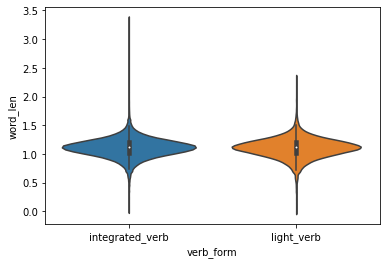

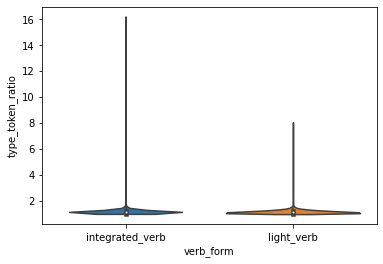

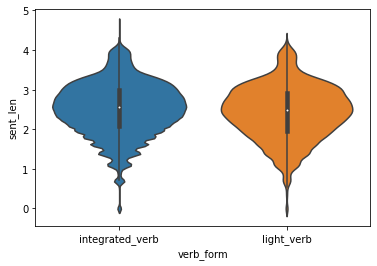

In [52]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
style_vars = ['word_len', 'type_token_ratio', 'sent_len']
for style_var in style_vars:
    sns.violinplot(x='verb_form', y=style_var, data=original_post_data)
    plt.show()

These look pretty much the same! What if we separate by verb type?

In [65]:
axs[0, 1]

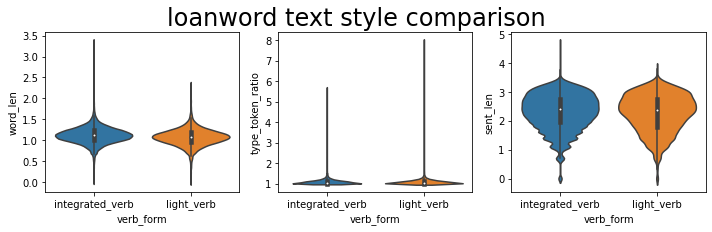

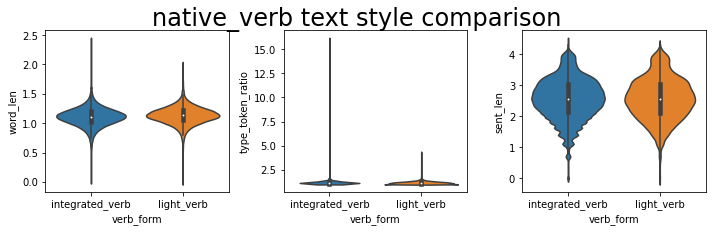

In [70]:
from math import floor
rows = 1
cols = len(style_vars)
for verb_type_i, data_i in original_post_data.groupby('post_verb_type'):
    f, axs = plt.subplots(rows, cols, figsize=(10,3))
    axs = axs.reshape(rows, cols)
    for j, style_var in enumerate(style_vars):
        row = int(floor(j / cols))
        col = j % cols
        ax = axs[row, col]
        sns.violinplot(x='verb_form', y=style_var, data=data_i, ax=ax)
    plt.suptitle(f'{verb_type_i} text style comparison', fontsize=24, y=1.06)
    plt.tight_layout()
    plt.show()

OK! They look pretty much the same. Let's test for a difference anyhow.

In [57]:
from scipy.stats import mannwhitneyu
for verb_type_i, data_i in original_post_data.groupby('post_verb_type'):
    print(f'testing verb type {verb_type_i}')
    integrated_verb_data_i = data_i[data_i.loc[:, 'verb_form']=='integrated_verb']
    light_verb_data_i = data_i[data_i.loc[:, 'verb_form']=='light_verb']
    for style_var in style_vars:
        integrated_verb_style_i = integrated_verb_data_i.loc[:, style_var]
        light_verb_style_i = light_verb_data_i.loc[:, style_var]
        # mean diff
        mean_diff_i = integrated_verb_style_i.mean() - light_verb_style_i.mean()
        test_stat, p_val = mannwhitneyu(integrated_verb_style_i, light_verb_style_i)
        print('style var %s has diff %.3E (test stat=%.3E, p=%.3E)'%(style_var, mean_diff_i, test_stat, p_val))

testing verb type loanword
style var word_len has diff 4.795E-02 (test stat=1.361E+08, p=1.120E-93)
style var type_token_ratio has diff -2.550E-03 (test stat=1.565E+08, p=3.182E-03)
style var sent_len has diff 3.652E-02 (test stat=1.551E+08, p=7.699E-05)
testing verb type native_verb
style var word_len has diff -2.594E-02 (test stat=8.683E+08, p=7.314E-62)
style var type_token_ratio has diff -2.104E-02 (test stat=8.660E+08, p=3.253E-66)
style var sent_len has diff -2.462E-03 (test stat=9.585E+08, p=1.262E-01)


OK! We actually do see consistent differences, although this could be a sample size artifact.

For loanwords, integrated verbs cooccur with:
- longer words
- lower type/token ratio
- longer sentences

For native words, integrated verbs cooccur with:
- shorter words
- lower type/token ratio

### Per-word regression

These effects could be driven by specific words, so we should try a regression to sort things out.

- fixed effect for word
- verb form